200


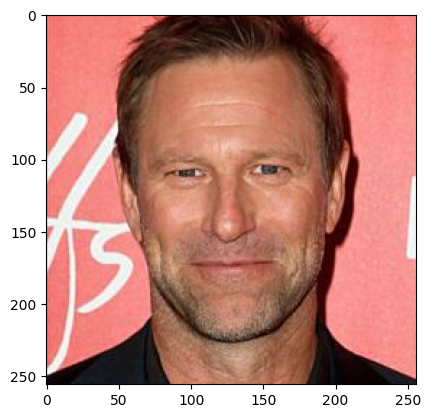

In [68]:
from datasets import load_dataset, Dataset
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt



# Load the dataset
base_dataset: Dataset = load_dataset("tonyassi/celebrity-1000", trust_remote_code=True, split="train", keep_in_memory=True).select(range(200))
image = next(iter(base_dataset))
pil_image = image["image"]
# Show first image in the dataset;
plt.imshow(pil_image)
# print length of the dataset
print(len(base_dataset))

In [69]:
# Define image transformations for ResNet-50
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-50 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# def preprocess_image(batch):
#     images = batch["image"]
#     # print len of images
#     print(len(images))
#     augmented_images = [transform(image) for image in images]
#     batch["image"] = augmented_images
#     return batch

def preprocess_image(batch):
    transformed_images = [transform(img) for img in batch["image"]]
    # print len of images
    print(len(transformed_images))
    # print shape of the first image
    print(transformed_images[0].shape)

    batch["pixel_values"] = transformed_images
    del batch["image"]
    return batch

dataset = base_dataset.map(preprocess_image, batched=True)


200
torch.Size([3, 224, 224])


Map: 100%|██████████| 200/200 [00:00<00:00, 220.75 examples/s]


In [70]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True) # type: ignore
test_dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=False) # type: ignore


In [71]:
import torch
from transformers import ResNetForImageClassification

# Number of classes
num_classes = dataset.features['label'].num_classes
print(num_classes)

labels = dataset.features['label'].names

# Create id2label mapping (dictionary of index -> label name)
id2label = {idx: label for idx, label in enumerate(labels)}

# Create label2id mapping (dictionary of label name -> index) 
label2id = {label: idx for idx, label in enumerate(labels)}


# Load ResNet-50
"""
The bare ResNet model outputting raw features without any specific head on top. 
This model is a PyTorch torch.nn.Module subclass. 
Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage and behavior.
"""
model = ResNetForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    # num_classes=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

# model
print(model.classifier)

# Add a classification head
model.classifier = torch.nn.Sequential(
    # torch.nn.Dropout(0.2),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=2048, out_features=num_classes, bias=True),
    # torch.nn.Softmax(dim=1)
)

# Print number of classifier head layers
print(len(model.classifier))


997


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([997]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([997, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2048, out_features=997, bias=True)
)
2


In [72]:
# Only train the classifier head
for param in model.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

In [73]:
print("Model config:", model.config)
# print("Dataset shape:", dataset[0]['input_ids'].shape)


Model config: ResNetConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "microsoft/resnet-50",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    4,
    6,
    3
  ],
  "downsample_in_bottleneck": false,
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "Aaron Eckhart",
    "1": "Aaron Paul",
    "2": "Aaron Rodgers",
    "3": "Aaron Taylor-Johnson",
    "4": "Abbi Jacobson",
    "5": "Abhishek Bachchan",
    "6": "Abigail Breslin",
    "7": "Abigail Spencer",
    "8": "Adam Brody",
    "9": "Adam Devine",
    "10": "Adam Driver",
    "11": "Adam Lambert",
    "12": "Adam Levine",
    "13": "Adam Sandler",
    "14": "Adam Scott",
    "15": "Adele",
    "16": "Adrian Grenier",
    "17": "Ad\u00e8le Exarchopoulos",
    "18": "Aidan Gillen",
    "19": "Aidan Turner",
    "20": "Aishwarya Rai",
    "21": "Aja Naomi Kin

In [74]:
# Time to train the model
from transformers import TrainingArguments, Trainer
import accelerate

print(accelerate.__version__)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=50,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    learning_rate=2e-4,
    remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset,
)

trainer.train()

0.26.0






                                                    

  7%|▋         | 535/7850 [59:17<6:56:58,  3.42s/it]



{'eval_loss': 6.865069389343262, 'eval_runtime': 21.9954, 'eval_samples_per_second': 9.093, 'eval_steps_per_second': 0.182, 'epoch': 1.0}






                                                    

  7%|▋         | 535/7850 [1:00:01<6:56:58,  3.42s/it]



{'eval_loss': 6.862597465515137, 'eval_runtime': 21.4294, 'eval_samples_per_second': 9.333, 'eval_steps_per_second': 0.187, 'epoch': 2.0}






                                                      

  7%|▋         | 535/7850 [1:00:45<6:56:58,  3.42s/it]



{'eval_loss': 6.844146728515625, 'eval_runtime': 21.9125, 'eval_samples_per_second': 9.127, 'eval_steps_per_second': 0.183, 'epoch': 3.0}






                                                      

  7%|▋         | 535/7850 [1:01:29<6:56:58,  3.42s/it]



{'eval_loss': 6.81358528137207, 'eval_runtime': 21.4995, 'eval_samples_per_second': 9.303, 'eval_steps_per_second': 0.186, 'epoch': 4.0}






                                                      

  7%|▋         | 535/7850 [1:02:13<6:56:58,  3.42s/it]



{'eval_loss': 6.760441780090332, 'eval_runtime': 21.806, 'eval_samples_per_second': 9.172, 'eval_steps_per_second': 0.183, 'epoch': 5.0}






                                                      

  7%|▋         | 535/7850 [1:02:57<6:56:58,  3.42s/it]



{'eval_loss': 6.671995162963867, 'eval_runtime': 21.426, 'eval_samples_per_second': 9.334, 'eval_steps_per_second': 0.187, 'epoch': 6.0}






                                                      

  7%|▋         | 535/7850 [1:03:40<6:56:58,  3.42s/it]



{'eval_loss': 6.548052787780762, 'eval_runtime': 21.3033, 'eval_samples_per_second': 9.388, 'eval_steps_per_second': 0.188, 'epoch': 7.0}






                                                      

  7%|▋         | 535/7850 [1:04:24<6:56:58,  3.42s/it]



{'eval_loss': 6.3877692222595215, 'eval_runtime': 21.7291, 'eval_samples_per_second': 9.204, 'eval_steps_per_second': 0.184, 'epoch': 8.0}






                                                      

  7%|▋         | 535/7850 [1:05:07<6:56:58,  3.42s/it]



{'eval_loss': 6.197021484375, 'eval_runtime': 21.5089, 'eval_samples_per_second': 9.298, 'eval_steps_per_second': 0.186, 'epoch': 9.0}






                                                      

  7%|▋         | 535/7850 [1:05:51<6:56:58,  3.42s/it]



{'eval_loss': 5.883981704711914, 'eval_runtime': 21.3821, 'eval_samples_per_second': 9.354, 'eval_steps_per_second': 0.187, 'epoch': 10.0}






                                                      

  7%|▋         | 535/7850 [1:06:34<6:56:58,  3.42s/it]



{'eval_loss': 5.546487808227539, 'eval_runtime': 21.2284, 'eval_samples_per_second': 9.421, 'eval_steps_per_second': 0.188, 'epoch': 11.0}






                                                      

  7%|▋         | 535/7850 [1:07:18<6:56:58,  3.42s/it]



{'eval_loss': 5.131240367889404, 'eval_runtime': 21.2447, 'eval_samples_per_second': 9.414, 'eval_steps_per_second': 0.188, 'epoch': 12.0}






                                                      

  7%|▋         | 535/7850 [1:08:01<6:56:58,  3.42s/it]



{'eval_loss': 4.589996337890625, 'eval_runtime': 21.1739, 'eval_samples_per_second': 9.446, 'eval_steps_per_second': 0.189, 'epoch': 13.0}






                                                      

  7%|▋         | 535/7850 [1:08:44<6:56:58,  3.42s/it]



{'eval_loss': 3.971445083618164, 'eval_runtime': 21.3142, 'eval_samples_per_second': 9.383, 'eval_steps_per_second': 0.188, 'epoch': 14.0}






                                                      

  7%|▋         | 535/7850 [1:09:27<6:56:58,  3.42s/it]



{'eval_loss': 3.306774854660034, 'eval_runtime': 21.1097, 'eval_samples_per_second': 9.474, 'eval_steps_per_second': 0.189, 'epoch': 15.0}






                                                      

  7%|▋         | 535/7850 [1:10:10<6:56:58,  3.42s/it]



{'eval_loss': 2.7350831031799316, 'eval_runtime': 21.1858, 'eval_samples_per_second': 9.44, 'eval_steps_per_second': 0.189, 'epoch': 16.0}






                                                      

  7%|▋         | 535/7850 [1:10:54<6:56:58,  3.42s/it]



{'eval_loss': 2.3699872493743896, 'eval_runtime': 21.1641, 'eval_samples_per_second': 9.45, 'eval_steps_per_second': 0.189, 'epoch': 17.0}






                                                      

  7%|▋         | 535/7850 [1:11:37<6:56:58,  3.42s/it]



{'eval_loss': 2.130464553833008, 'eval_runtime': 21.5751, 'eval_samples_per_second': 9.27, 'eval_steps_per_second': 0.185, 'epoch': 18.0}






                                                      

  7%|▋         | 535/7850 [1:12:21<6:56:58,  3.42s/it]



{'eval_loss': 2.1395020484924316, 'eval_runtime': 21.281, 'eval_samples_per_second': 9.398, 'eval_steps_per_second': 0.188, 'epoch': 19.0}






                                                      

  7%|▋         | 535/7850 [1:13:04<6:56:58,  3.42s/it]



{'eval_loss': 1.945050835609436, 'eval_runtime': 21.4603, 'eval_samples_per_second': 9.32, 'eval_steps_per_second': 0.186, 'epoch': 20.0}






                                                      

  7%|▋         | 535/7850 [1:13:47<6:56:58,  3.42s/it]



{'eval_loss': 1.763443946838379, 'eval_runtime': 21.0116, 'eval_samples_per_second': 9.519, 'eval_steps_per_second': 0.19, 'epoch': 21.0}






                                                      

  7%|▋         | 535/7850 [1:14:30<6:56:58,  3.42s/it]



{'eval_loss': 1.6597155332565308, 'eval_runtime': 21.3225, 'eval_samples_per_second': 9.38, 'eval_steps_per_second': 0.188, 'epoch': 22.0}






                                                      

  7%|▋         | 535/7850 [1:15:14<6:56:58,  3.42s/it]



{'eval_loss': 1.519934058189392, 'eval_runtime': 21.8584, 'eval_samples_per_second': 9.15, 'eval_steps_per_second': 0.183, 'epoch': 23.0}






                                                      

  7%|▋         | 535/7850 [1:15:58<6:56:58,  3.42s/it]



{'eval_loss': 1.392194390296936, 'eval_runtime': 21.3957, 'eval_samples_per_second': 9.348, 'eval_steps_per_second': 0.187, 'epoch': 24.0}






                                                      

  7%|▋         | 535/7850 [1:16:42<6:56:58,  3.42s/it]



{'eval_loss': 1.219366192817688, 'eval_runtime': 21.445, 'eval_samples_per_second': 9.326, 'eval_steps_per_second': 0.187, 'epoch': 25.0}






                                                      

  7%|▋         | 535/7850 [1:17:26<6:56:58,  3.42s/it]



{'eval_loss': 1.0736305713653564, 'eval_runtime': 21.3986, 'eval_samples_per_second': 9.346, 'eval_steps_per_second': 0.187, 'epoch': 26.0}






                                                      

  7%|▋         | 535/7850 [1:18:09<6:56:58,  3.42s/it]



{'eval_loss': 0.9762365818023682, 'eval_runtime': 21.1896, 'eval_samples_per_second': 9.439, 'eval_steps_per_second': 0.189, 'epoch': 27.0}






                                                      

  7%|▋         | 535/7850 [1:18:52<6:56:58,  3.42s/it]



{'eval_loss': 0.969302773475647, 'eval_runtime': 21.2237, 'eval_samples_per_second': 9.423, 'eval_steps_per_second': 0.188, 'epoch': 28.0}






                                                      

  7%|▋         | 535/7850 [1:19:35<6:56:58,  3.42s/it]



{'eval_loss': 0.8049008250236511, 'eval_runtime': 21.5238, 'eval_samples_per_second': 9.292, 'eval_steps_per_second': 0.186, 'epoch': 29.0}






                                                      

  7%|▋         | 535/7850 [1:20:18<6:56:58,  3.42s/it]



{'eval_loss': 0.6911144852638245, 'eval_runtime': 21.2908, 'eval_samples_per_second': 9.394, 'eval_steps_per_second': 0.188, 'epoch': 30.0}






                                                      

  7%|▋         | 535/7850 [1:21:01<6:56:58,  3.42s/it]



{'eval_loss': 0.5641338229179382, 'eval_runtime': 21.0732, 'eval_samples_per_second': 9.491, 'eval_steps_per_second': 0.19, 'epoch': 31.0}






                                                      

  7%|▋         | 535/7850 [1:21:44<6:56:58,  3.42s/it]



{'eval_loss': 0.468550443649292, 'eval_runtime': 21.1627, 'eval_samples_per_second': 9.451, 'eval_steps_per_second': 0.189, 'epoch': 32.0}






                                                      

  7%|▋         | 535/7850 [1:22:28<6:56:58,  3.42s/it]



{'eval_loss': 0.42246055603027344, 'eval_runtime': 21.5211, 'eval_samples_per_second': 9.293, 'eval_steps_per_second': 0.186, 'epoch': 33.0}






                                                      

  7%|▋         | 535/7850 [1:23:11<6:56:58,  3.42s/it]



{'eval_loss': 0.3588356673717499, 'eval_runtime': 21.0603, 'eval_samples_per_second': 9.497, 'eval_steps_per_second': 0.19, 'epoch': 34.0}






                                                      

  7%|▋         | 535/7850 [1:23:54<6:56:58,  3.42s/it]



{'eval_loss': 0.29219767451286316, 'eval_runtime': 21.217, 'eval_samples_per_second': 9.426, 'eval_steps_per_second': 0.189, 'epoch': 35.0}






                                                      

  7%|▋         | 535/7850 [1:24:37<6:56:58,  3.42s/it]



{'eval_loss': 0.24764932692050934, 'eval_runtime': 21.2541, 'eval_samples_per_second': 9.41, 'eval_steps_per_second': 0.188, 'epoch': 36.0}






                                                      

  7%|▋         | 535/7850 [1:25:20<6:56:58,  3.42s/it]



{'eval_loss': 0.2151927798986435, 'eval_runtime': 21.158, 'eval_samples_per_second': 9.453, 'eval_steps_per_second': 0.189, 'epoch': 37.0}






                                                      

  7%|▋         | 535/7850 [1:26:04<6:56:58,  3.42s/it]



{'eval_loss': 0.19319665431976318, 'eval_runtime': 21.3451, 'eval_samples_per_second': 9.37, 'eval_steps_per_second': 0.187, 'epoch': 38.0}






                                                      

  7%|▋         | 535/7850 [1:26:48<6:56:58,  3.42s/it]



{'eval_loss': 0.1719948798418045, 'eval_runtime': 21.5002, 'eval_samples_per_second': 9.302, 'eval_steps_per_second': 0.186, 'epoch': 39.0}






                                                      

  7%|▋         | 535/7850 [1:27:31<6:56:58,  3.42s/it]



{'eval_loss': 0.15172700583934784, 'eval_runtime': 21.0258, 'eval_samples_per_second': 9.512, 'eval_steps_per_second': 0.19, 'epoch': 40.0}






                                                      

  7%|▋         | 535/7850 [1:28:13<6:56:58,  3.42s/it]



{'eval_loss': 0.14063405990600586, 'eval_runtime': 21.2909, 'eval_samples_per_second': 9.394, 'eval_steps_per_second': 0.188, 'epoch': 41.0}






                                                      

  7%|▋         | 535/7850 [1:28:57<6:56:58,  3.42s/it]



{'eval_loss': 0.13069431483745575, 'eval_runtime': 21.0661, 'eval_samples_per_second': 9.494, 'eval_steps_per_second': 0.19, 'epoch': 42.0}






                                                      

  7%|▋         | 535/7850 [1:29:40<6:56:58,  3.42s/it]



{'eval_loss': 0.12465787678956985, 'eval_runtime': 21.2576, 'eval_samples_per_second': 9.408, 'eval_steps_per_second': 0.188, 'epoch': 43.0}






                                                      

  7%|▋         | 535/7850 [1:30:23<6:56:58,  3.42s/it]



{'eval_loss': 0.12221746146678925, 'eval_runtime': 21.1298, 'eval_samples_per_second': 9.465, 'eval_steps_per_second': 0.189, 'epoch': 44.0}






                                                      

  7%|▋         | 535/7850 [1:31:06<6:56:58,  3.42s/it]



{'eval_loss': 0.1115490272641182, 'eval_runtime': 21.2736, 'eval_samples_per_second': 9.401, 'eval_steps_per_second': 0.188, 'epoch': 45.0}






                                                      

  7%|▋         | 535/7850 [1:31:49<6:56:58,  3.42s/it]



{'eval_loss': 0.10472443699836731, 'eval_runtime': 21.1721, 'eval_samples_per_second': 9.446, 'eval_steps_per_second': 0.189, 'epoch': 46.0}






                                                      

  7%|▋         | 535/7850 [1:32:33<6:56:58,  3.42s/it]



{'eval_loss': 0.1012943834066391, 'eval_runtime': 21.7621, 'eval_samples_per_second': 9.19, 'eval_steps_per_second': 0.184, 'epoch': 47.0}






                                                      

  7%|▋         | 535/7850 [1:33:17<6:56:58,  3.42s/it]



{'eval_loss': 0.1004972755908966, 'eval_runtime': 21.0681, 'eval_samples_per_second': 9.493, 'eval_steps_per_second': 0.19, 'epoch': 48.0}






                                                      

  7%|▋         | 535/7850 [1:34:01<6:56:58,  3.42s/it]



{'eval_loss': 0.10003059357404709, 'eval_runtime': 21.5662, 'eval_samples_per_second': 9.274, 'eval_steps_per_second': 0.185, 'epoch': 49.0}






                                                      

  7%|▋         | 535/7850 [1:34:45<6:56:58,  3.42s/it]


100%|██████████| 200/200 [36:12<00:00, 10.86s/it]s/it]

{'eval_loss': 0.10175702720880508, 'eval_runtime': 21.6439, 'eval_samples_per_second': 9.24, 'eval_steps_per_second': 0.185, 'epoch': 50.0}
{'train_runtime': 2172.8608, 'train_samples_per_second': 4.602, 'train_steps_per_second': 0.092, 'train_loss': 2.583907165527344, 'epoch': 50.0}


TrainOutput(global_step=200, training_loss=2.583907165527344, metrics={'train_runtime': 2172.8608, 'train_samples_per_second': 4.602, 'train_steps_per_second': 0.092, 'total_flos': 2.307674170368e+17, 'train_loss': 2.583907165527344, 'epoch': 50.0})